In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon, Circle
from matplotlib.collections import PatchCollection
from shapely.geometry import Point as ShapelyPoint
from shapely.geometry.polygon import Polygon as ShapelyPolygon

#for testing
import time
start_time = time.time()

In [25]:
#The functions below make it easier to understand what information is being retrieved later in the code
#defines the value to use for max() to get third entity
def get_mult(ent):
    return ent[2]
#defines the value to use for max() to get second entity
def get_y(ent):
    return ent[1]
#defines the value to use for max() to get first entity
def get_x(ent):
    return ent[0]
def get_best_score(ent):
    return ent[0]
def get_best_index(ent):
    return ent[1]

In [26]:
#Stores the list of drones for output; empty until filled by the algorithm
drone_list = []

In [27]:
#Minimum coverage needed to be provided by the algorithm
#Format: decimal (1 = 100% coverage)
min_coverage = 1
print("Minimum Coverage: " + str(min_coverage * 100) + "%")

Minimum Coverage: 100%


In [28]:
#The section below calculates the height and coverage radiuof the network module on the drone
#Parameters for the caclulation:
wavelength = 0.125
directivity_transmitter_dBi = 14
directivity_reciever_dBi = 5
power_transmitter_dBm = -10
power_reciever_dBm = -70
aperature_angle = 60

#convert angle in degrees to radians
theta = aperature_angle*(np.pi/180)

#calculations
height = wavelength / (4 * np.pi * 10**((power_reciever_dBm - 
                                         (power_transmitter_dBm + directivity_transmitter_dBi + 
                                          directivity_reciever_dBi))/20))
coverage_radius = int(height * np.tan(theta))
height = int(height)

print("Height: " + str(height) + " meters")
print("Coverage Radius: " + str(coverage_radius) + " meters")

Height: 88 meters
Coverage Radius: 153 meters


In [29]:
#should be calculated from another function - yet to be created
#number of drones in each member of the population (each map)
num_drones = 1
print("Number of drones in swarm: " + str(num_drones))

Number of drones in swarm: 1


In [30]:
#population size for GA
pop_size = 500
print("Population size for genetic algorithm: " + str(pop_size))

Population size for genetic algorithm: 500


In [31]:
#mutation rate for GA
#Format: decimal (1 = 100% coverage)
mutation_rate = 0.01
print("Mutation rate for genetic algorithm: " + str(mutation_rate * 100) + "%")

Mutation rate for genetic algorithm: 1.0%


In [32]:
#holds best fitness info
    #includes fitness score and index in population, respectively
best_fitness = (0, -1)

In [33]:
#list of vertices in the polygon (in order of drawing)
#also calculates the minimum and maximum x and y values for the polygon
map_vertex_list = np.array([(0,0), (0, 1000), (1000,1000),(1000,0)])
xmin = get_x(min(map_vertex_list, key=get_x))
xmax = get_x(max(map_vertex_list, key=get_x))
ymin = get_y(min(map_vertex_list, key=get_y))
ymax = get_y(max(map_vertex_list, key=get_y))

In [34]:
#list of "hot spots" 
#format: (x coordinate, y coordinate, multiplicity - number of users at that location)
tot_users = 0
map_density_list = np.array([(100,100,5), (400, 400, 1), (0, 400, 10), (400, 0, 3), (1000, 1000, 5), (0, 800, 1), (800, 0, 1), (100, 0, 8), (1000, 300, 4), (400, 800, 10), (600, 550, 3), (900, 0, 9), (150,150,1), (650, 650, 1), (700, 700, 10), (690, 80, 15), (750, 100, 5), (50, 50, 5), (1000,400, 10)])
for (_,_,u) in map_density_list:
    tot_users += u
print("Total users in this map: " + str(tot_users))

Total users in this map: 107


In [35]:
#fitness to strive for with GA
optimal_fitness = tot_users * min_coverage
print("Optimal fitness: " + str(optimal_fitness))

Optimal fitness: 107


In [36]:
#Creates two polygon objects used for later calculations
map_poly = Polygon(map_vertex_list, True)
shapely_poly = ShapelyPolygon(map_vertex_list)

In [37]:
#checks if a point is within the map polygon
#returns boolean: true or false
def polygon_contains_point(point):
    point_to_check = ShapelyPoint(get_x(point), get_y(point))
    return shapely_poly.contains(point_to_check)

In [38]:
#draws appropriate map - make more flexible with different polygons
def draw_map(map_vertex_list, map_density_list, drone_list):
    
    patches = [map_poly]
    
    max_mult = get_mult(max(map_density_list, key=get_mult))
    #the following only runs after the computation has taken place and the drone positions have been calculated
    #handle drone selection circles
    for coord in drone_list:

        temp_circle = Circle(coord, radius=coverage_radius)
        patches.append(temp_circle)

    fig, ax = plt.subplots()
    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
    ax.add_collection(p)

    for coord in drone_list:
        plt.scatter(get_x(coord),get_y(coord),c='b')
    
    for (x, y, m) in map_density_list:
        if (m/max_mult) <= (1/3):
            plt.scatter(x, y, c='g')
        elif (m/max_mult) <= (2/3):
            plt.scatter(x, y, c='y')
        else:
            plt.scatter(x, y, c='r')
            
            
    plt.axis([xmin-10,xmax+10,ymin-10,ymax+10])
    plt.axis('scaled')
    plt.show()

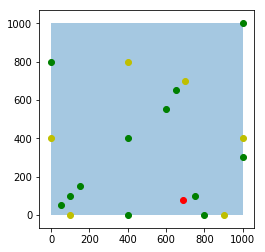

In [39]:
draw_map(map_vertex_list, map_density_list, drone_list)

In [40]:
#GA SETUP

def setup():
    global population, drone_list, best_fitness
    drone_list = []
    population = []
    best_fitness = (-1, 0)

    #fills population with pop_size random but appropriate entries
    for _ in range(pop_size):
        temp_pop = []
        for _ in range(num_drones):
            add_to_pop = (np.random.randint(xmin, xmax), np.random.randint(ymin,ymax))
            while (not polygon_contains_point(add_to_pop)):
                add_to_pop = (np.random.randint(xmin, xmax), np.random.randint(ymin,ymax))
            temp_pop.append(add_to_pop)

        population.append(temp_pop)
setup()

In [41]:
#GA DRAW formulas

In [42]:
#append the fitness to every proposed map in population
    #fitness is defined as the number of users covered under a given map
def fitness():
    global best_fitness, population
    adj_population = []
    index = -1
    for proposed_map in population:
        score = 0
        cluster_exclusion_list = []
        for drone in proposed_map:

            for (x, y, m) in map_density_list:
                hot_spot = (x, y, m)
                dist = np.sqrt((get_x(hot_spot)-get_x(drone))**2 + (get_y(hot_spot)-get_y(drone))**2)
                if (dist <= coverage_radius and (hot_spot not in cluster_exclusion_list)):
                    cluster_exclusion_list.append(hot_spot)
                    for _ in range(get_mult(hot_spot)):
                        adj_population.append(proposed_map)
                    score += get_mult(hot_spot)
        index += 1
        if (score >= get_best_score(best_fitness)):
            best_fitness = (score, index)
    return adj_population

In [43]:
#Computes the next generation for the GA
#also handles mutation
def draw(adj_population):
    global population
    population = []
    mutation_check = 0
    for n in range(pop_size):
        add_to_pop = []
        for m in range(num_drones):
            rand1 = np.random.randint(0, len(adj_population))
            rand2 = np.random.randint(0, len(adj_population))
            
            
            if (mutation_check == 1/mutation_rate):
                mut_rand = np.random.randint(0,2)
                if (mut_rand == 0):
                    add_to_pop.append((np.random.randint(xmin, xmax), get_y(adj_population[rand2][m])))
                else:
                    add_to_pop.append((get_x(adj_population[rand1][m]), np.random.randint(ymin, ymax)))
                mutation_check = 0
            else:
                add_to_pop.append((get_x(adj_population[rand1][m]), get_y(adj_population[rand2][m])))
        
        mutation_check += 1
        population.append(add_to_pop)

In [44]:
def illustrate_final():
    global drone_list, population, best_fitness
    drone_list = population[get_best_index(best_fitness)]
    list_ = [list(elem) for elem in population[get_best_index(best_fitness)]]
    for tup in list_:
        tup.append(height)
    print("\nBest fitness: " + str(get_best_score(best_fitness)) + " \nProposed Map: " + str(list_))
    #illustrate solution
    draw_map(map_vertex_list, map_density_list, drone_list)

In [45]:
def illustrate_intermediate():
    global best_fitness, num_drones
    if (num_drones == 1):
        print(str(num_drones) + " drone failed | Best fitness: " + str(get_best_score(best_fitness)) + " \nContinuing with " + str(num_drones+1) + " drones")
    else:
        print(str(num_drones) + " drones failed | Best fitness: " + str(get_best_score(best_fitness)) + " \nContinuing with " + str(num_drones+1) + " drones")

1 drone failed | Best fitness: 30 
Continuing with 2 drones
2 drones failed | Best fitness: 49 
Continuing with 3 drones
3 drones failed | Best fitness: 63 
Continuing with 4 drones
4 drones failed | Best fitness: 73 
Continuing with 5 drones
5 drones failed | Best fitness: 87 
Continuing with 6 drones
6 drones failed | Best fitness: 97 
Continuing with 7 drones
7 drones failed | Best fitness: 102 
Continuing with 8 drones
8 drones failed | Best fitness: 105 
Continuing with 9 drones
9 drones failed | Best fitness: 106 
Continuing with 10 drones
10 drones failed | Best fitness: 103 
Continuing with 11 drones

Best fitness: 107 
Proposed Map: [[142, 748, 88], [641, 626, 88], [668, 818, 88], [36, 136, 88], [407, 443, 88], [37, 322, 88], [445, 816, 88], [972, 870, 88], [882, 373, 88], [800, 103, 88], [388, 69, 88]]


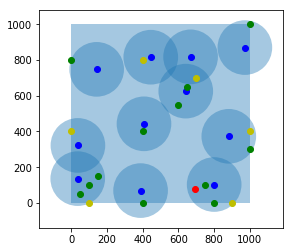

In [46]:
#loop for GA

#optimize: instead of max iterations, use for how many generations the fitness stays the same 
#(score stays the same for 50 iterations, move on)
while(get_best_score(best_fitness) < optimal_fitness):
    setup()
    same_fitness_count = 0
    fit = fitness()
    #makes calculation time a function of these 2 variables
    #allows for more iterations for harder solutions
    calc_limit = num_drones * len(map_density_list) 
    while(get_best_score(best_fitness) < optimal_fitness and same_fitness_count < calc_limit):
        prev_fitness = get_best_score(best_fitness)
        draw(fit)
        fit = fitness()
        if (get_best_score(best_fitness) == prev_fitness):
            same_fitness_count += 1
        else:
            same_fitness_score = 0
    if (get_best_score(best_fitness) < optimal_fitness):
        illustrate_intermediate()
    num_drones += 1
illustrate_final()


In [47]:
#OLD loop for GA
# fit = fitness()
# it = 0
# while(get_best_score(best_fitness) < optimal_fitness):
#     draw(fit)
#     print("Best score: " + str(get_best_score(best_fitness)) + " | Proposed Map: " + str(population[get_best_index(best_fitness)]))
#     fit = fitness()
#     it += 1
# print("Best score: " + str(get_best_score(best_fitness)) + " | Proposed Map: " + str(population[get_best_index(best_fitness)]))
# print("total generations: " + str(it))

In [48]:
#for testing
print('The algorithm took', time.time()-start_time, 'seconds.')

The algorithm took 373.1176710128784 seconds.


What if the learning from the previous popultion could be built upon? just add a random other drone and continue: see updated file